# 0. Introduction and methodology


The objective of this project is to emperically determine whether or not the best configuration obtained from running hyperparameter optimization on a subset of a dataset will also be the best configuration when training on the full dataset. If this is the case, then using a subset of the full dataset can either allow for a much more rapid optimization process or allow for a much wider search space when optimizing hyperparameters.


In this notebook, I'm analyzing the results from a proof-of-concept trial to see if this kind of empirical study is feasible. For this proof-of-concept, I did two rounds of learning rate optimization using raytune (with the ASHA scheduler) on the MNIST dataset with 100 samples for each round of optimization. For the first round (cnn2_mnist_lr_optim_20221019), I used an 80/20 train/val split on the MNIST train set. For the second round (cnn2_mnist_lr_tenth_optim_20221019), I took a random sample of 10% of the MNIST train set and used an 80/20 train/val split of that subset. 

# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

cnn2_full_dataset_path =  "../hparam_results/cnn2_mnist_lr_optim_20221019/results_cnn2_mnist_lr_optim_20221019.csv"
cnn2_tenth_dataset_path = "../hparam_results/cnn2_mnist_lr_tenth_optim_20221019/results_cnn2_mnist_lr_tenth_optim_20221019.csv"
figures_root = "./figures/"

# 2. Get best lr and loss

In [2]:
results_full = pd.read_csv(cnn2_full_dataset_path,index_col=0)
results_tenth = pd.read_csv(cnn2_tenth_dataset_path,index_col=0)

best_lr_full = results_full.sort_values(by='val_loss', ascending=True)
best_lr_tenth = results_tenth.sort_values(by='val_loss', ascending=True)

best_lr_full_val = best_lr_full['config/optimizer_cfg/args/lr'].values[0]
best_lr_tenth_val = best_lr_tenth['config/optimizer_cfg/args/lr'].values[0]

best_lr_full_loss = best_lr_full['val_loss'].values[0]
best_lr_tenth_loss = best_lr_tenth['val_loss'].values[0]
print(f"best lr (full dataset): {best_lr_full_val}, loss: {best_lr_full_loss}")
print(f"best lr (10% dataset): {best_lr_tenth_val}, loss: {best_lr_tenth_loss}")

best lr (full dataset): 0.001605632328165, loss: 0.0059941853396594
best lr (10% dataset): 0.0129528276152004, loss: 0.0101235173642635


# 3. lr vs. loss figures

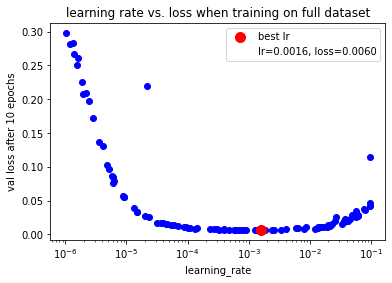

In [3]:
fig, ax = plt.subplots()

ax.scatter(results_full['config/optimizer_cfg/args/lr'],
            results_full['val_loss'], c='b')
ax.scatter(best_lr_full_val, best_lr_full_loss, c='r', s=100, label='best lr')
ax.plot([],[], ' ', label=f"lr={best_lr_full_val:.4f}, loss={best_lr_full_loss:.4f}")
ax.legend()
ax.set_xscale('log')
ax.set_xlabel("learning_rate")
ax.set_ylabel("val loss after 10 epochs")
ax.set_title("learning rate vs. loss when training on full dataset")
plt.savefig(os.path.join(figures_root, 'cnn2_mnist_best_lr_20221019.jpg'))

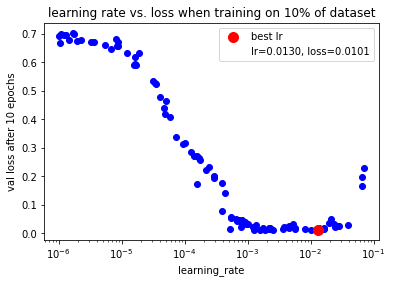

In [4]:
fig, ax = plt.subplots()

results_tenth_ten_epoch = results_tenth
ax.scatter(results_tenth_ten_epoch['config/optimizer_cfg/args/lr'],
            results_tenth_ten_epoch['val_loss'], c='b')
ax.scatter(best_lr_tenth_val, best_lr_tenth_loss, c='r', s=100, label='best lr')
ax.plot([],[], ' ', label=f"lr={best_lr_tenth_val:.4f}, loss={best_lr_tenth_loss:.4f}")
ax.legend()
ax.set_xscale('log')
ax.set_xlabel("learning_rate")
ax.set_ylabel("val loss after 10 epochs")
ax.set_title("learning rate vs. loss when training on 10% of dataset")
plt.savefig(os.path.join(figures_root, 'cnn2_mnist_best_lr_tenth_20221019.jpg'))

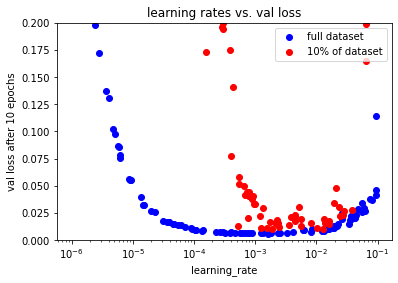

In [5]:
fig, ax = plt.subplots()

results_tenth_ten_epoch = results_tenth
ax.scatter(results_full['config/optimizer_cfg/args/lr'],
            results_full['val_loss'], c='b', label='full dataset')
ax.scatter(results_tenth['config/optimizer_cfg/args/lr'],
            results_tenth['val_loss'], c='r', label='10% of dataset')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel("learning_rate")
ax.set_ylabel("val loss after 10 epochs")
ax.set_ylim([0, 0.2])
ax.set_title("learning rates vs. val loss")
plt.savefig(os.path.join(figures_root, 'cnn2_lr_20221020_combined_20221019.jpg'))

# 4. Get trials that made it to 10 epochs

In [6]:
num_trials_10_epochs_full = len(results_full[results_full['training_iteration']==10])
num_trials_10_epochs_10percent = len(results_tenth[results_tenth['training_iteration']==10])

print(f"out of {len(results_full)} trials on full dataset, {num_trials_10_epochs_full} made it to 10 epochs")
print(f"out of {len(results_tenth)} trials on 10% of dataset, {num_trials_10_epochs_10percent} made it to 10 epochs")

out of 100 trials on full dataset, 72 made it to 10 epochs
out of 99 trials on 10% of dataset, 6 made it to 10 epochs


# 5. Discussion

When running on 10% of the dataset, the lr vs. loss curve appears much rougher when compared to the full dataset. Only 6 out of 99 trials made it to 10 epochs when training on 10% of the full dataset (all others were stopped early due to performance) compared to 72 out of 100 when trained on the entire dataset. 

A major contributor for this would be the propensity for overfitting since we're reducing the size of the training set- so ray tune probably stopped the trials once they started overfitting. These trainings did not use any kind of early stopping callback outside of ray tune, so some of these losses might have been recorded after the model was overfitted on the reduced training set (thus unrepresentative of their real performance).

Additionally, while generating the splits, both the training and validation set sizes were reduced, so there were fewer samples used when calcuating the validation loss. 

Even though the the actual best losses differ by an order of magnitude (0.0016 for the full dataset vs. 0.013 for the 10% of the full dataset), visual inspection of the combined plot show that there is some room for argument in saying that there is an overlap between the minimum loss for the partial dataset and full dataset. Additionally, the loss when using a learning rate ~$10^{-2}$ on the full dataset appears marginally higher than the true optimal loss. Therefore it's plausible that using a subset of the full dataset to infer the optimal hyperparameters is a worthwhile hyperparameter tuning strategy. 

# 6. Next steps


**short-term**

- Build two models- one with the best learning rate for the full dataset and one with the best learning rate for 10% of the full dataset- and train each of these on the full dataset. Run each model on the MNIST test set and compare the classification metrics

- re-sample the train/val split for the mnist dataset using stratified sampling. Then take subsamples of 75%, 50%, 25%, and 10% of those train/val splits (again, stratified) to aim for more reliable results

- repeat these trials but evaluate the model trained on full training dataset and model trained on 10% of training set on the same validation set.

**long-term**
- repeat this trial with other aspects of training once we get an idea of an ideal learning rate (e.g. momentum, optimizer type, learning rate scheduling, data augmentation policy, etc.)

- conduct these trials with several datasets on several different learning tasks

- conduct these trials with several different model architectures